# Logistic 回归
Logistic回归中，输出(Y = 1)的对数几率是输入 x 的线性函数，思路 : 

1. 先拟合决策边界（不局限于线性，还可以是多项式）
2. 再建立这个边界和分类概率的关系
3. 从而得到二分类情况下的概率

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from torch.autograd import Variable

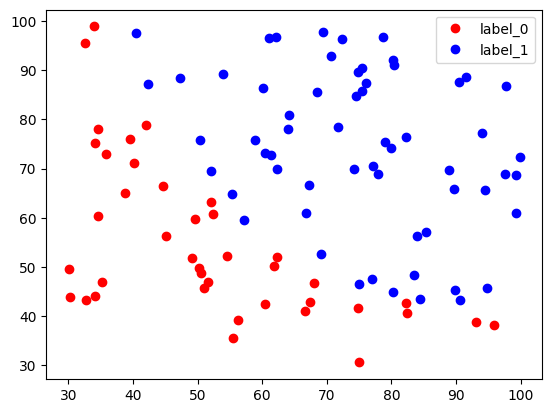

In [22]:
# 获取并查看数据

with open('data.txt') as f :
    data = f.read().split('\n')
    data = [row.split(',') for row in data][:-1]
    label0 = np.array([(float(row[0]), float(row[1])) for row in data if row[2] == '0'])
    label1 = np.array([(float(row[0]), float(row[1])) for row in data if row[2] == '1'])
x0, y0 = label0[:, 0], label0[:, 1]
x1, y1 = label1[:, 0], label1[:, 1]
plt.plot(x0, y0, 'ro', label = 'label_0')
plt.plot(x1, y1, 'bo', label = 'label_1')
plt.legend(loc = 'best')

In [23]:
import torch

# 获得训练数据
x = np.concatenate((label0, label1), axis = 0)
x_data = torch.from_numpy(x).float()

y = [[0] for i in range(label0.shape[0])]
y += [[1] for i in range(label1.shape[0])]
y_data = torch.FloatTensor(y)

In [24]:
# 定义模型

class logisticRegression(nn.Module) :
    def __init__(self) :
        super().__init__()
        self.line = nn.Linear(2, 1)
        self.smd = nn.Sigmoid()
    def forward(self, x) :
        x = self.line(x)
        return self.smd(x)

logistic = logisticRegression()

if torch.cuda.is_available() :
    logistic.cuda()

In [25]:
# 定义损失函数为二分类交叉熵(Binary Cross Entropy)
criterion = nn.BCELoss()
# 定义优化函数为随机梯度下降(Sochastic Gradient Descent)
optimizer = optim.SGD(logistic.parameters(), lr = 1e-3, momentum = 0.9)

解释一下两个部分

#### BCELoss()
它的定义是 $loss(o, t) = \frac 1 n \sum_i(t[i] * log(o[i]) + (1 - t[i]) * log(1 - o[i]))$

以上来源于[torch.nn.BCELoss](http://pytorch.org/docs/master/nn.html?highlight=nn%20bceloss#torch.nn.BCELoss)
#### SGD函数，它带有一个参数 `momentum = 0.9`，这表示动量。

这种优化方法来源于[On the importance of initialization and momentum in deep learning](http://www.cs.toronto.edu/~hinton/absps/momentum.pdf)

它的优化方式为 : $$v = \rho * v + g \\ p = p - lr * v$$
其中，p, g, v, $\rho$ 分别表示待更新的参数parameters，求得的梯度gradient，速度velocity，和动量momentum

以上来源于[官网](http://pytorch.org/docs/master/optim.html)关于torch.optim.SGD的note

In [26]:
# 开始训练
epoches = 50000
for epoch in range(epoches) :
    if torch.cuda.is_available() :
        x = Variable(x_data).cuda()
        y = Variable(y_data).cuda()
    else :
        x = Variable(x_data)
        y = Variable(y_data)
    
    # forward 前向计算
    out = logistic(x)
    loss = criterion(out, y)
    
    # 计算准确率
    print_loss = loss.data
    mask = out.ge(0.5).float()
    # print('size : {} - {}'.format(mask.size(), y.size()))
    correct = (mask == y).sum()
    acc = correct.data/ x.size(0)
    
    # BP回朔
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10000 == 0 :
        print('*' * 10)
        print('epoch {}'.format(epoch + 1))
        print('loss is {:.4f}'.format(print_loss))
        print('correct rate is {:.4f}'.format(acc))

**********
epoch 10000
loss is 53.5947
correct rate is 0.4000
**********
epoch 20000
loss is 53.5947
correct rate is 0.4000
**********
epoch 30000
loss is 53.5947
correct rate is 0.4000
**********
epoch 40000
loss is 53.5947
correct rate is 0.4000
**********
epoch 50000
loss is 53.5947
correct rate is 0.4000


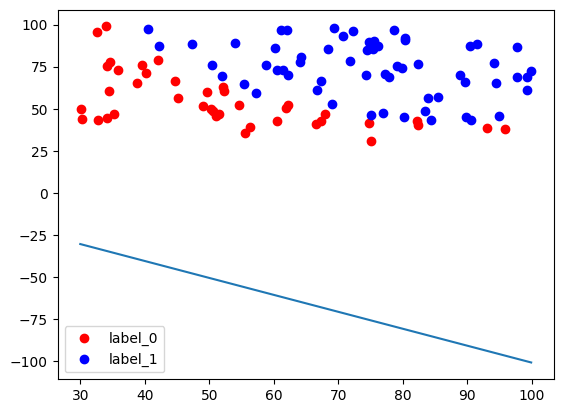

In [27]:
weight = logistic.line.weight.data[0].cpu()
w0, w1 = weight[0].cpu(), weight[1].cpu()
b = logistic.line.bias.data[0].cpu()

plt.plot(x0, y0, 'ro', label = 'label_0')
plt.plot(x1, y1, 'bo', label = 'label_1')
plt.legend(loc = 'best')
plot_x = np.arange(30, 100, 0.1)
plot_y = (-w0 * plot_x - b) / w1
plt.plot(plot_x, plot_y)
plt.show()